# Calibration

## Data

In [1]:
from sklearn.datasets import make_classification

X, y = make_classification(**{
    'n_samples': 1_000,
    'n_features': 5,
    'n_informative': 2,
    'n_redundant': 2,
    'n_repeated': 0,
    'n_classes': 2,
    'n_clusters_per_class': 2,
    'random_state': 37
})

print(f'X shape = {X.shape}, y shape {y.shape}')

X shape = (1000, 5), y shape (1000,)


## Modeling

In [2]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=37)

X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((900, 5), (100, 5), (900,), (100,))

In [3]:
from sklearn.linear_model import LogisticRegression

M = LogisticRegression(
    max_iter=5_000, 
    n_jobs=-1, 
    random_state=37
)
M.fit(X_tr, y_tr)

LogisticRegression(max_iter=5000, n_jobs=-1, random_state=37)

In [4]:
from sklearn.calibration import CalibratedClassifierCV

I = CalibratedClassifierCV(M, cv=2, method='isotonic')
I.fit(X_te, y_te)

CalibratedClassifierCV(base_estimator=LogisticRegression(max_iter=5000,
                                                         n_jobs=-1,
                                                         random_state=37),
                       cv=2, method='isotonic')

In [5]:
S = CalibratedClassifierCV(M, cv=2, method='sigmoid')
S.fit(X_te, y_te)

CalibratedClassifierCV(base_estimator=LogisticRegression(max_iter=5000,
                                                         n_jobs=-1,
                                                         random_state=37),
                       cv=2)

## Predicted probabilities

In [6]:
import pandas as pd

y_m = pd.Series(M.predict_proba(X_te)[:,1])
y_i = pd.Series(I.predict_proba(X_te)[:,1])
y_s = pd.Series(S.predict_proba(X_te)[:,1])

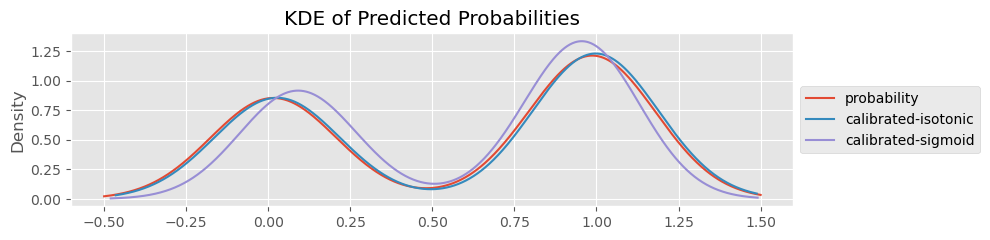

In [7]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 2.5))

y_m.plot(kind='kde', label='probability', ax=ax)
y_i.plot(kind='kde', label='calibrated-isotonic', ax=ax)
y_s.plot(kind='kde', label='calibrated-sigmoid', ax=ax)

ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('KDE of Predicted Probabilities')

plt.tight_layout()

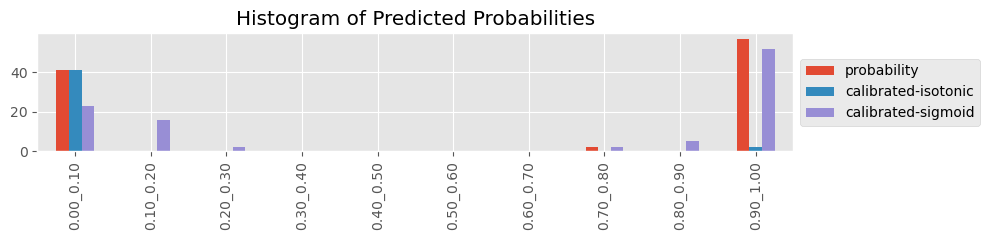

In [8]:
import numpy as np

intervals = [(left, left + 0.1) for left in np.arange(0, 1.0, 0.1)]

fig, ax = plt.subplots(figsize=(10, 2.5))

pd.DataFrame({
    'probability': [y_m[(y_m >= L) & (y_m < R)].shape[0] for L, R in intervals],
    'calibrated-isotonic': [y_i[(y_i >= L) & (y_i < R)].shape[0] for L, R in intervals],
    'calibrated-sigmoid': [y_s[(y_s >= L) & (y_s < R)].shape[0] for L, R in intervals]
}, index=[f'{L:.2f}_{R:.2f}' for L, R in intervals]) \
.plot(kind='bar', ax=ax)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Histogram of Predicted Probabilities')

plt.tight_layout()

## Calibration curves

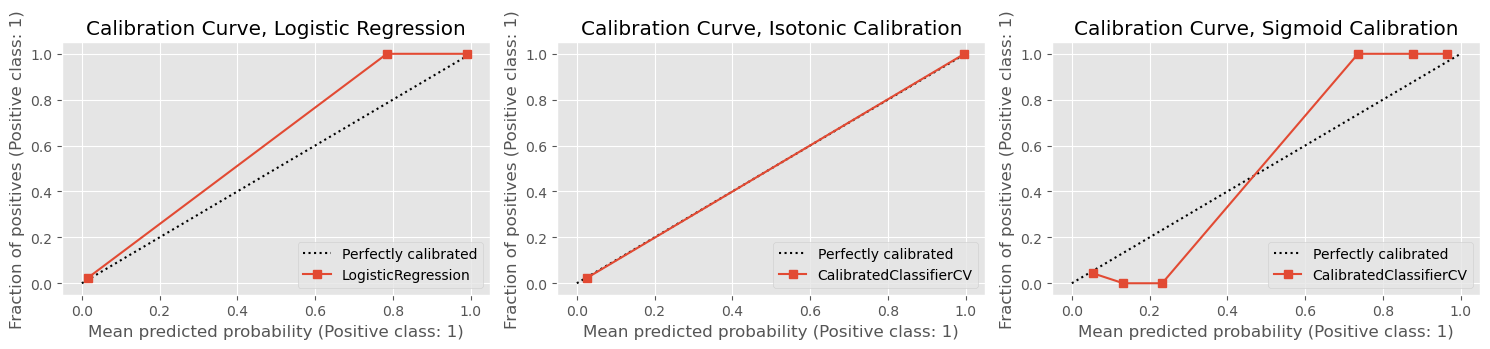

In [9]:
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay

fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))

CalibrationDisplay.from_estimator(
    M,
    X_te,
    y_te,
    n_bins=10,
    ax=ax[0]
)

CalibrationDisplay.from_estimator(
    I,
    X_te,
    y_te,
    n_bins=10,
    ax=ax[1]
)

CalibrationDisplay.from_estimator(
    S,
    X_te,
    y_te,
    n_bins=10,
    ax=ax[2]
)

ax[0].set_title('Calibration Curve, Logistic Regression')
ax[1].set_title('Calibration Curve, Isotonic Calibration')
ax[2].set_title('Calibration Curve, Sigmoid Calibration')

plt.tight_layout()

## Gaussian Mixture

In [10]:
from sklearn.mixture import GaussianMixture

def get_gmm_model(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=50)
    gmm.fit(X)
    
    score = gmm.score(X)
    
    return {
        'k': k,
        'score': score,
        'model': gmm
    }

model_df = {
    'M': pd.DataFrame([get_gmm_model(pd.DataFrame({'y': y_m}), k) for k in range(2, 11)]),
    'I': pd.DataFrame([get_gmm_model(pd.DataFrame({'y': y_i}), k) for k in range(2, 8)]),
    'S': pd.DataFrame([get_gmm_model(pd.DataFrame({'y': y_s}), k) for k in range(2, 11)])
}

In [11]:
model_df['M']

,k,score,model
0,2,1.474473,"GaussianMixture(max_iter=50, n_components=2)"
1,3,2.029017,"GaussianMixture(max_iter=50, n_components=3)"
2,4,2.141844,"GaussianMixture(max_iter=50, n_components=4)"
3,5,2.580403,"GaussianMixture(max_iter=50, n_components=5)"
4,6,2.639431,"GaussianMixture(max_iter=50, n_components=6)"
5,7,2.676213,"GaussianMixture(max_iter=50, n_components=7)"
6,8,2.695147,"GaussianMixture(max_iter=50, n_components=8)"
7,9,2.732365,"GaussianMixture(max_iter=50, n_components=9)"
8,10,2.739582,"GaussianMixture(max_iter=50, n_components=10)"


In [12]:
model_df['I']

,k,score,model
0,2,2.225388,"GaussianMixture(max_iter=50, n_components=2)"
1,3,4.006186,"GaussianMixture(max_iter=50, n_components=3)"
2,4,4.946469,"GaussianMixture(max_iter=50, n_components=4)"
3,5,4.994388,"GaussianMixture(max_iter=50, n_components=5)"
4,6,5.033068,"GaussianMixture(max_iter=50, n_components=6)"
5,7,5.033096,"GaussianMixture(max_iter=50, n_components=7)"


In [13]:
model_df['S']

,k,score,model
0,2,0.834789,"GaussianMixture(max_iter=50, n_components=2)"
1,3,0.855690,"GaussianMixture(max_iter=50, n_components=3)"
2,4,1.124100,"GaussianMixture(max_iter=50, n_components=4)"
3,5,1.156751,"GaussianMixture(max_iter=50, n_components=5)"
4,6,1.214234,"GaussianMixture(max_iter=50, n_components=6)"
5,7,1.216182,"GaussianMixture(max_iter=50, n_components=7)"
6,8,1.277675,"GaussianMixture(max_iter=50, n_components=8)"
7,9,1.259467,"GaussianMixture(max_iter=50, n_components=9)"
8,10,1.284225,"GaussianMixture(max_iter=50, n_components=10)"


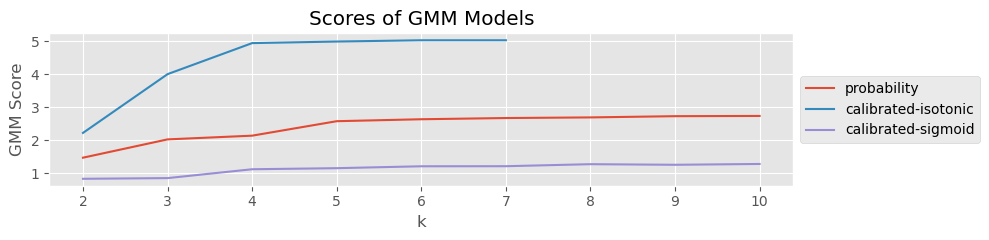

In [14]:
fig, ax = plt.subplots(figsize=(10, 2.5))

model_df['M'].set_index(['k'])['score'].plot(label='probability', ax=ax)
model_df['I'].set_index(['k'])['score'].plot(label='calibrated-isotonic', ax=ax)
model_df['S'].set_index(['k'])['score'].plot(label='calibrated-sigmoid', ax=ax)

ax.set_ylabel('GMM Score')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Scores of GMM Models')

plt.tight_layout()

## Rescale calibrated probabilities

In [15]:
gmm = model_df['I'].iloc[4].model

In [16]:
gmm_info = pd.DataFrame({
    'label': range(gmm.n_components),
    'mean': np.ravel(gmm.means_),
    'variance': np.ravel(gmm.covariances_),
    'weights': gmm.weights_
})

gmm_info = gmm_info \
    .assign(order=gmm_info.sort_values(['mean']).index) \
    .sort_values(['order']) \
    .assign(prob=np.arange(0, 1 + (10 / (gmm.n_components - 1) / 10), 10 / (gmm.n_components - 1) / 10))

gmm_info

,label,mean,variance,weights,order,prob
0,0,0.023810,0.000001,0.37,0,0.0
5,5,0.045232,0.000001,0.02,1,0.2
4,4,0.086247,0.000001,0.01,2,0.4
2,2,0.918531,0.000002,0.02,3,0.6
3,3,0.055410,0.000001,0.01,4,0.8
1,1,1.000000,0.000001,0.57,5,1.0


In [17]:
pd.Series(gmm.predict(pd.DataFrame({'y': y_i}))).value_counts().sort_index()

0    37
1    57
2     2
3     1
4     1
5     2
dtype: int64

In [18]:
pd.Series([gmm_info[gmm_info['label']==label].iloc[0].order 
           for label in gmm.predict(pd.DataFrame({'y': y_i}))]) \
    .value_counts() \
    .sort_index()

0.0    37
1.0     2
2.0     1
3.0     2
4.0     1
5.0    57
dtype: int64

In [19]:
pd.Series([gmm_info[gmm_info['label']==label].iloc[0].prob 
           for label in gmm.predict(pd.DataFrame({'y': y_i}))]) \
    .value_counts() \
    .sort_index()

0.0    37
0.2     2
0.4     1
0.6     2
0.8     1
1.0    57
dtype: int64

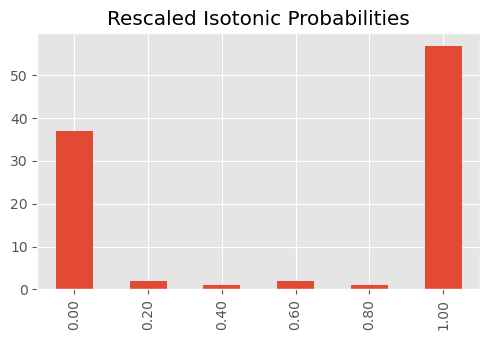

In [20]:
fig, ax = plt.subplots(figsize=(5, 3.5))

pd.Series([gmm_info[gmm_info['label']==label].iloc[0].prob 
           for label in gmm.predict(pd.DataFrame({'y': y_i}))]) \
    .value_counts() \
    .sort_index() \
    .plot(kind='bar', ax=ax)

ax.set_xticklabels([f'{float(t.get_text()):.2f}' for t in ax.get_xticklabels()])
ax.set_title('Rescaled Isotonic Probabilities')

plt.tight_layout()